# 1. Read prices from CSV file 

In [32]:
# Import the package pandas as pd
import pandas as pd

# Read the csv file using read_csv method of pandas
prices = pd.read_csv('security_prices_2000_2019.csv', index_col=0)

# Set the index to datetime
prices.index = pd.to_datetime(prices.index)

# Convert daily frequency to monthly frequency
prices = prices.asfreq('BM')
prices.tail()

,Gold,Silver,Crude Oil,Platinum,Corn,Sugar,Wheat,EUR-USD,USD-JPY,GBP-USD,...,GBP-EUR,S&P500,Dow Jones Industrial Average,NASDAQ,Russell 2000,TLT,TLH,IEF,IEI,SHY
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,143.750000,17.15,91.680000,88.040001,14.75,6.49,4.96,1.106195,106.438003,1.218650,...,1.10170,287.988037,259.769470,186.290970,147.207321,145.166946,150.266266,112.615204,126.135376,83.959152
2019-09-30,138.869995,15.92,90.720001,83.470001,15.18,6.67,5.30,1.089966,108.069000,1.228999,...,1.11732,293.591644,265.368683,188.000900,150.206024,141.276627,147.556595,111.279495,125.408447,83.846458
2019-10-31,142.429993,16.92,90.400002,87.930000,15.15,6.61,5.43,1.115449,108.789001,1.290173,...,1.15673,300.081421,266.821045,196.235474,154.285233,139.703934,146.834732,111.488579,125.774956,84.108833
2019-11-29,137.860001,15.92,92.959999,84.580002,14.52,6.74,5.67,1.101176,109.512001,1.291289,...,1.17250,310.943817,277.662384,204.221085,160.557877,139.135162,145.714386,110.722435,125.309669,84.069160
2019-12-31,142.899994,16.68,102.480003,90.930000,14.80,7.02,5.85,1.120230,108.873001,1.311303,...,1.17039,319.978424,282.624176,212.157883,165.031876,134.686310,142.816101,109.694862,125.110435,84.199486


# 2. Calculate strategy returns 

In [33]:
# Import the package numpy as np
import numpy as np

# Calculate strategy returns
def get_ts_mom_strategy_returns(data, lookback=12, hold=1):

    df = pd.DataFrame()

    # Define stratregy logic
    df['lookback_returns'] = data.pct_change(lookback)
    df['future_hold_period_returns'] = data.pct_change(hold).shift(-hold)
    df = df.dropna()
    df['positions'] = np.where(df['lookback_returns'] > 0, 1, -1)

    # Calculate Strategy Returns
    df['strategy_returns'] = df['future_hold_period_returns'] * df['positions']
    return df['strategy_returns']

# 3. Analyse strategy performance

In [34]:
def analytics_returns(data_strategy_returns, title_name):

    # Calculate Sharpe ratio
    data_strategy_returns['equal_weight_portfolio'] = data_strategy_returns.mean(axis=1)
    
    sharpe = (np.mean(data_strategy_returns) /
              np.std(data_strategy_returns)*(12**0.5))
    
    sharpe.plot.bar(figsize=(10, 7), color='blue')
    plt.ylabel('Sharpe')
    plt.title(title_name)
    plt.show()

    # Calculate the cumulative strategy returns
    cum_rets = (data_strategy_returns/100 + 1).cumprod()
    cum_rets.plot(figsize=(10, 7))

    # Set title and labels for the plot
    plt.title(title_name, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.show()

    total_months = len(cum_rets)
    analytics = pd.DataFrame()

    # Calculate annalised returns
    analytics['Annualised Returns'] = (cum_rets.iloc[-2]**(12/total_months)-1)*100

    # Calculate annualised volatility
    analytics['Annualised Volatility'] = np.std(data_strategy_returns)*(12**0.5)

    # Calculate maximum drawdown
    def calc_drawdown(cum_rets):

        # Calculate the running maximum
        running_max = np.maximum.accumulate(cum_rets.dropna())

        # Ensure the value never drops below 1
        running_max[running_max < 1] = 1

        # Calculate the percentage drawdown
        drawdown = (cum_rets)/running_max - 1
        return drawdown

    analytics['Max Drawdown'] = cum_rets.apply(calc_drawdown, axis=0).min()*100

    print(analytics)

### Store securities according to their classes

In [35]:
commodities = ['Gold', 'Silver', 'Crude Oil','Platinum', 'Corn', 'Sugar', 'Wheat']

currencies = ['EUR-USD', 'USD-JPY', 'GBP-USD', 'USD-CAD', 'USD-CHF', 'GBP-EUR']

stock_indices = ['S&P500', 'Dow Jones Industrial Average','NASDAQ', 'Russell 2000']

treasuries = ['TLT', 'TLH', 'IEF', 'IEI', 'SHY']

### 3.1 Commodities

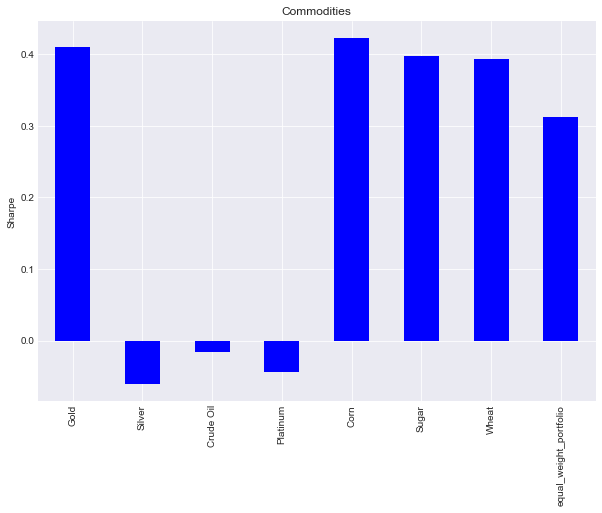

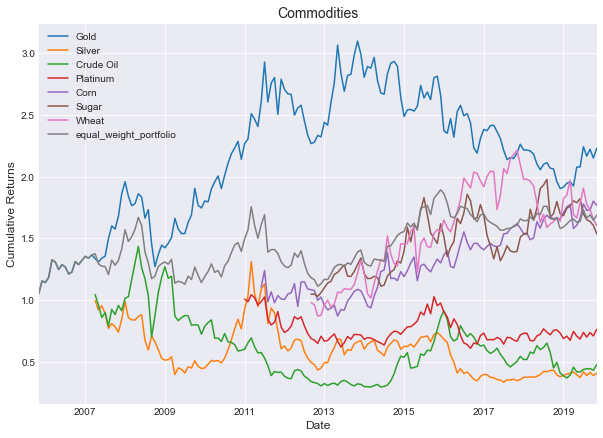

                        Annualised Returns  Annualised Volatility  \
Gold                              5.587999              17.733484   
Silver                           -6.490354              31.644710   
Crude Oil                        -5.791867              32.304494   
Platinum                         -2.411574              20.651280   
Corn                              4.270232              21.463085   
Sugar                             3.413545              20.036589   
Wheat                             3.640014              24.007168   
equal_weight_portfolio            3.608230              16.075348   

                        Max Drawdown  
Gold                      -38.570468  
Silver                    -74.465200  
Crude Oil                 -79.407674  
Platinum                  -41.586106  
Corn                      -29.773235  
Sugar                     -29.027182  
Wheat                     -28.225207  
equal_weight_portfolio    -36.679583  


In [36]:
# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

data_strategy_returns = prices[commodities].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns, 'Commodities')

### 3.2 Stock indices

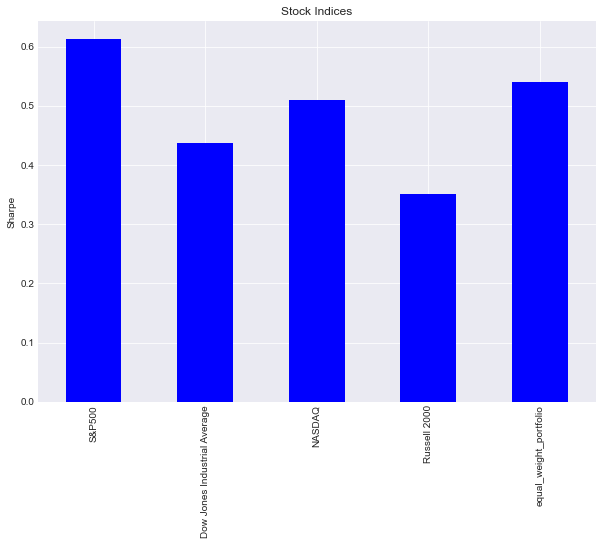

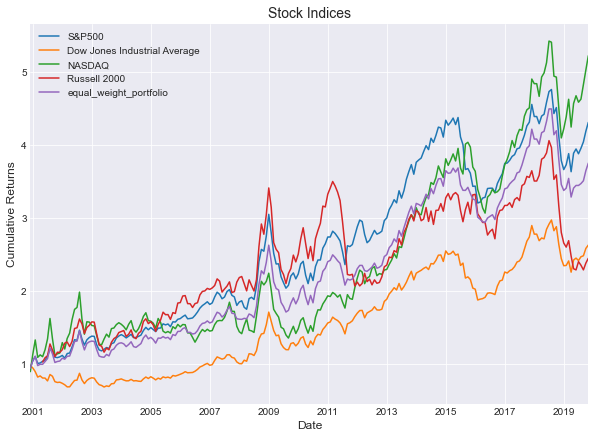

                              Annualised Returns  Annualised Volatility  \
S&P500                                  7.836061              14.257434   
Dow Jones Industrial Average            5.129655              13.874053   
NASDAQ                                  8.875897              21.770607   
Russell 2000                            4.682363              18.893079   
equal_weight_portfolio                  7.055446              15.015613   

                              Max Drawdown  
S&P500                          -33.133562  
Dow Jones Industrial Average    -31.224560  
NASDAQ                          -39.561901  
Russell 2000                    -43.585447  
equal_weight_portfolio          -34.818873  


In [37]:
data_strategy_returns = prices[stock_indices].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns, 'Stock Indices')

### 3.3 Currencies

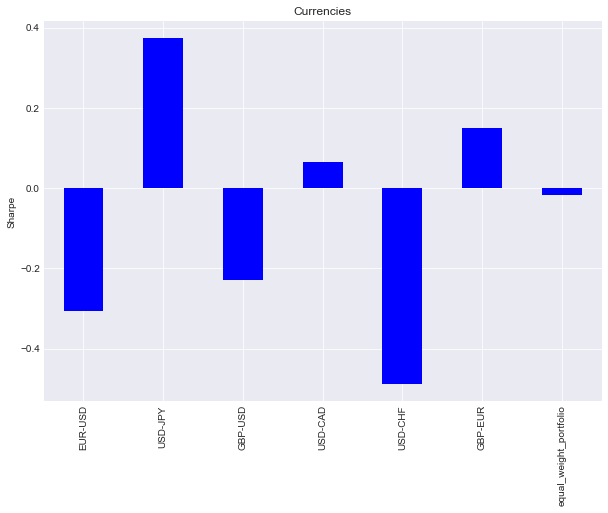

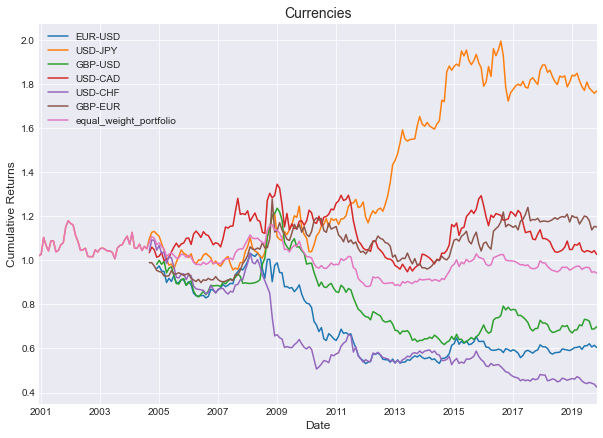

                        Annualised Returns  Annualised Volatility  \
EUR-USD                          -2.531661               9.515401   
USD-JPY                           3.012658               9.153255   
GBP-USD                          -1.946037               8.754004   
USD-CAD                           0.226125               9.253297   
USD-CHF                          -4.251877              10.343020   
GBP-EUR                           0.753705               8.633966   
equal_weight_portfolio           -0.279035               6.395750   

                        Max Drawdown  
EUR-USD                   -48.526710  
USD-JPY                   -18.915811  
GBP-USD                   -50.057051  
USD-CAD                   -29.563885  
USD-CHF                   -61.084658  
GBP-EUR                   -24.820574  
equal_weight_portfolio    -25.300060  


In [38]:
data_strategy_returns = prices[currencies].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns,'Currencies')

### 3.4 Treasuries

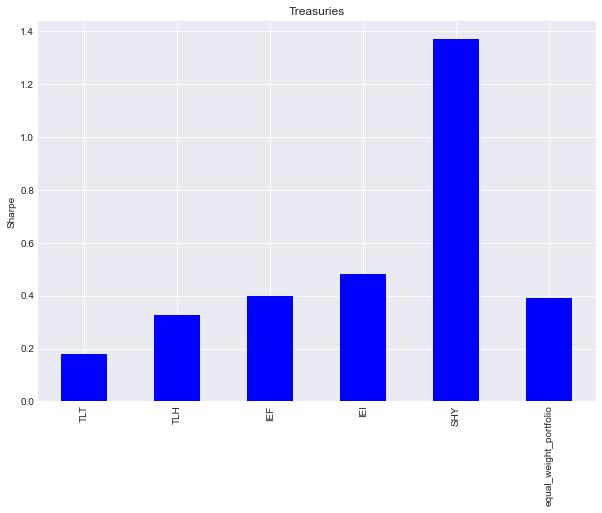

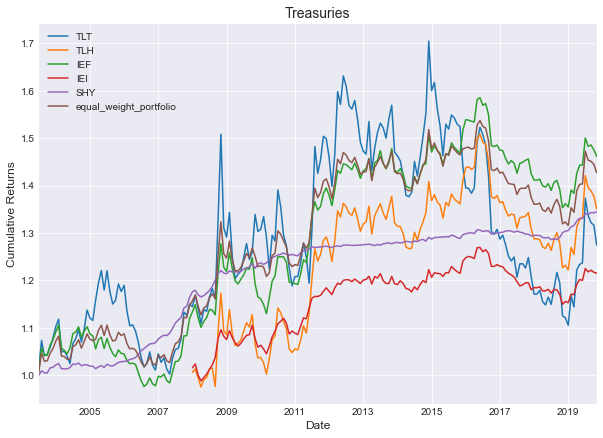

                        Annualised Returns  Annualised Volatility  \
TLT                               1.688561              12.952153   
TLH                               1.971966               8.987928   
IEF                               2.397365               6.271707   
IEI                               1.203139               3.510917   
SHY                               1.810238               1.323385   
equal_weight_portfolio            2.266232               5.995974   

                        Max Drawdown  
TLT                       -35.161082  
TLH                       -18.978424  
IEF                       -14.655894  
IEI                        -9.457173  
SHY                        -1.586925  
equal_weight_portfolio    -14.416283  


In [39]:
data_strategy_returns = prices[treasuries].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns,'Treasuries')